In [97]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras import initializers
from tensorflow.keras.models import load_model
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [98]:
# "Time Series Forecasting" -- File: "BeerWineLiquor.csv" --
# Source:https://www.kaggle.com/bulentsiyah/for-simple-exercises-time-series-forecasting?select=BeerWineLiquor.csv
dataset = pd.read_csv('sample_data/BeerWineLiquor.csv')

In [99]:
# rename columns
dataset.rename(columns={'beer': 'Beer_Sales'}, inplace=True)
dataset.rename(columns={'date': 'DATE'}, inplace='True')
dataset.head(10)

,DATE,Beer_Sales
0,1/1/1992,1509
1,2/1/1992,1541
2,3/1/1992,1597
3,4/1/1992,1675
4,5/1/1992,1822
5,6/1/1992,1775
6,7/1/1992,1912
7,8/1/1992,1862
8,9/1/1992,1770
9,10/1/1992,1882


In [100]:
# 'DATE' column is concerted from 'object' type to 'datetime' type
dataset['DATE'] = pd.to_datetime(dataset['DATE'])
dataset['Year'] = dataset['DATE'].apply(lambda date: date.year)
dataset['Month'] = dataset['DATE'].apply(lambda date: date.month)
dataset.head(10)

,DATE,Beer_Sales,Year,Month
0,1992-01-01,1509,1992,1
1,1992-02-01,1541,1992,2
2,1992-03-01,1597,1992,3
3,1992-04-01,1675,1992,4
4,1992-05-01,1822,1992,5
5,1992-06-01,1775,1992,6
6,1992-07-01,1912,1992,7
7,1992-08-01,1862,1992,8
8,1992-09-01,1770,1992,9
9,1992-10-01,1882,1992,10


In [101]:
# DATE column is set as an index
dataset = dataset.set_index(['DATE'])
dataset.head(5)

,Beer_Sales,Year,Month
DATE,,,
1992-01-01,1509,1992,1
1992-02-01,1541,1992,2
1992-03-01,1597,1992,3
1992-04-01,1675,1992,4
1992-05-01,1822,1992,5


In [102]:
# get some info
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 324 entries, 1992-01-01 to 2018-12-01
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Beer_Sales  324 non-null    int64
 1   Year        324 non-null    int64
 2   Month       324 non-null    int64
dtypes: int64(3)
memory usage: 10.1 KB


In [103]:
num_to_name = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct',
               11: 'Nov', 12: 'Dec'}
# dataset['Month'] = dataset['Month'].map(num_to_name)
dataset['Month'] = dataset['Month'].apply(lambda num: num_to_name[num])
dataset.head(10)

,Beer_Sales,Year,Month
DATE,,,
1992-01-01,1509,1992,Jan
1992-02-01,1541,1992,Feb
1992-03-01,1597,1992,Mar
1992-04-01,1675,1992,Apr
1992-05-01,1822,1992,May
1992-06-01,1775,1992,Jun
1992-07-01,1912,1992,Jul
1992-08-01,1862,1992,Aug
1992-09-01,1770,1992,Sep


C:\Users\bender\miniconda3\envs\tf_gpu\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Density')

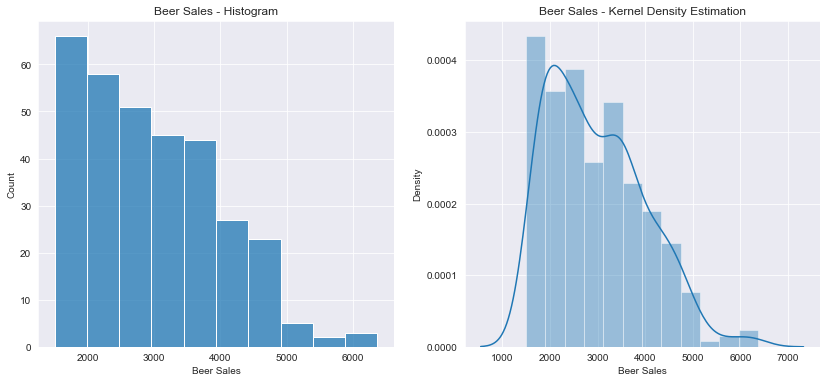

In [104]:
# Sales histogram and kernel density plots
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
sns.histplot(dataset['Beer_Sales'], kde=False, bins=10, ax=axs[0])
axs[0].set_title('Beer Sales - Histogram')
axs[0].set_xlabel('Beer Sales')
axs[0].set_ylabel('Count')

sns.distplot(dataset['Beer_Sales'], kde=True, hist=10, ax=axs[1])
axs[1].set_title('Beer Sales - Kernel Density Estimation')
axs[1].set_xlabel('Beer Sales')
axs[1].set_ylabel('Density')

Text(0.5, 1.0, 'Sales grouped by Year')

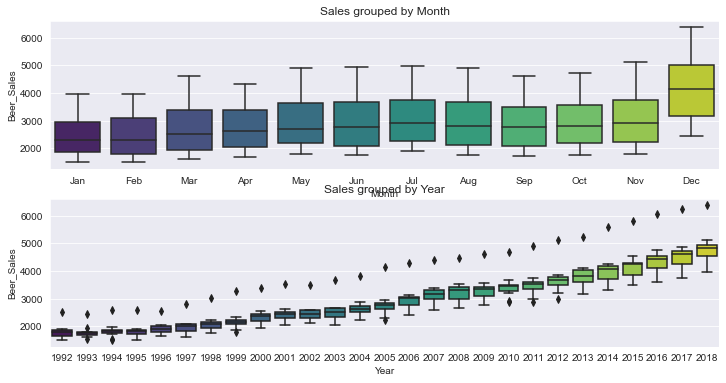

In [105]:
# Box plots of Beer sales grouped by Month and Year
figs, axs = plt.subplots(2, 1, figsize=(12, 6))

sns.boxplot(x='Month', data=dataset, y='Beer_Sales', palette='viridis', ax=axs[0])
axs[1].set_xlabel('Month')
axs[0].set_ylabel('Beer_Sales')
axs[0].set_title("Sales grouped by Month")

sns.boxplot(x='Year', data=dataset, y='Beer_Sales', palette='viridis', ax=axs[1])
axs[1].set_xlabel('Year')
axs[1].set_ylabel('Beer_Sales')
axs[1].set_title("Sales grouped by Year")

In [106]:
# drop Year and Month columns from the dataset
data = dataset.drop(['Year', 'Month'], axis=1)
data.head()

,Beer_Sales
DATE,
1992-01-01,1509
1992-02-01,1541
1992-03-01,1597
1992-04-01,1675
1992-05-01,1822


Text(0.5, 1.0, 'Beer Sales Times Series')

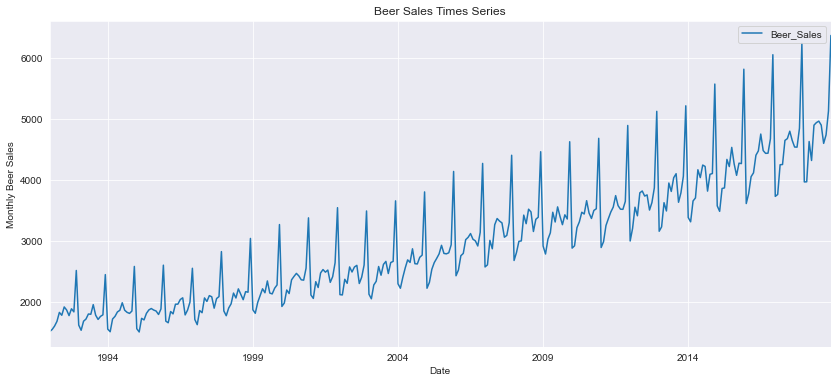

In [107]:
# Time series plot
data.plot(figsize=(14, 6))
plt.xlabel('Date')
plt.ylabel('Monthly Beer Sales')
plt.title("Beer Sales Times Series")

In [108]:
# Test size 12 months
test_size = 12

# Split dataset to training and testing
training_data = data.iloc[:len(dataset) - test_size]
testing_data = data.iloc[-test_size:]
print(f"The size of the training data set is {len(training_data)}")
print(f"The size of the testing data set is {len(testing_data)}")

The size of the training data set is 312
The size of the testing data set is 12


### Monthly sales future forecasting using LSTM

In [109]:
# Tha last records of the dataset
data.tail()

,Beer_Sales
DATE,
2018-08-01,4898
2018-09-01,4598
2018-10-01,4737
2018-11-01,5130
2018-12-01,6370


In [110]:
data_scaler = MinMaxScaler()
scaled_set = data_scaler.fit_transform(data)
length = 12
n_features = 1
data_generator = TimeseriesGenerator(scaled_set, scaled_set, length=length, batch_size=1)

In [111]:
tf.random.set_seed(0)
np.random.seed(0)

TRAIN = True

if TRAIN:
    initializer = tf.keras.initializers.he_uniform(seed=0)
    model = Sequential()
    model.add(LSTM(units=12, activation='relu', input_shape=(length, n_features), kernel_initializer=initializer))
    model.add(Dense(units=1, activation='linear', kernel_initializer=initializer))
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=opt, loss='mse')
    model.fit(data_generator, epochs=10, shuffle=False)
    model.save('LSTM_beer_part2')
else:
    model = load_model('.\LSTM_beer_part2')

Epoch 1/10
312/312 [==============================] - 6s 14ms/step - loss: 0.0093
Epoch 2/10
312/312 [==============================] - 4s 14ms/step - loss: 0.0090
Epoch 3/10
312/312 [==============================] - 4s 14ms/step - loss: 0.0086
Epoch 4/10
312/312 [==============================] - 4s 14ms/step - loss: 0.0081
Epoch 5/10
312/312 [==============================] - 4s 14ms/step - loss: 0.0076
Epoch 6/10
312/312 [==============================] - 5s 15ms/step - loss: 0.0070
Epoch 7/10
312/312 [==============================] - 5s 15ms/step - loss: 0.0065
Epoch 8/10
312/312 [==============================] - 5s 16ms/step - loss: 0.0061
Epoch 9/10
312/312 [==============================] - 4s 14ms/step - loss: 0.0059
Epoch 10/10
312/312 [==============================] - 4s 14ms/step - loss: 0.0056
INFO:tensorflow:Assets written to: LSTM_beer_part2\assets


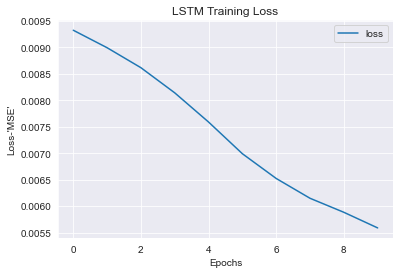

In [112]:
# Training performance
loss = pd.DataFrame(model.history.history)
loss.plot()
plt.title('LSTM Training Loss')
plt.xlabel('Epochs')
plt.ylabel("Loss-'MSE'");

In [113]:
# Determining all LSTM predictions on the Training Set
full_training_outputs = []
batch = scaled_set[:length].reshape((1, length, n_features))

for i in range(len(scaled_set[length:])):
    full_train_out = model.predict(batch)[0]
    full_training_outputs.append(full_train_out)
    batch = np.append(batch[:, 1:, :], [[scaled_set[length:][i]]], axis=1)

# Inverse transforming for actual training values
f_train = scaled_set[length:]
f_train = data_scaler.inverse_transform(f_train)

# Inverse transforming the LSTM predictions on the training set
f_train_predictions = data_scaler.inverse_transform(full_training_outputs)

C:\Users\bender\miniconda3\envs\tf_gpu\lib\site-packages\seaborn\distributions.py:1708: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.0, 'Kernel Density Estimation ')

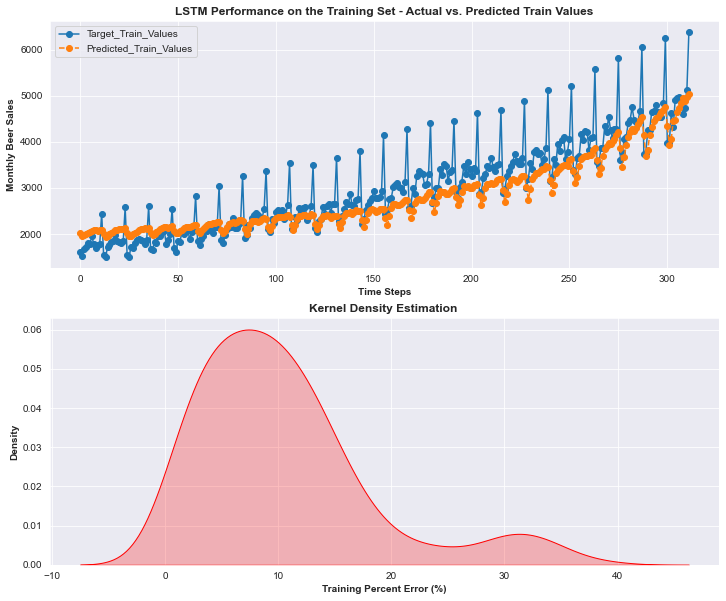

In [114]:
fig, axs = plt.subplots(2, 1, figsize=(12, 10))

axs[0].plot(f_train, marker='o', linestyle='-', label='Target_Train_Values')
axs[0].plot(f_train_predictions, marker='o', linestyle='dashed', label='Predicted_Train_Values')
axs[0].set_title('LSTM Performance on the Training Set - Actual vs. Predicted Train Values', fontweight='bold')
#
axs[0].legend()
axs[0].set_xlabel('Time Steps', fontweight='bold')
axs[0].set_ylabel('Monthly Beer Sales', fontweight='bold')

# Training Percent Error distribution plot
f_train_err = abs((f_train - f_train_predictions) / f_train) * 100
f_train_err = pd.DataFrame(f_train_err, columns=['Training Error'])

sns.kdeplot(f_train_err['Training Error'], shade=True, color='r', kernel='gau', ax=axs[1])
axs[1].set_xlabel('Training Percent Error (%)', fontweight='bold')
axs[1].set_ylabel('Density', fontweight='bold');
axs[1].set_title('Kernel Density Estimation ', fontweight='bold')

In [115]:
# Summary statistics of the LSTM Prediction Error
f_train_err.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Training Error,312.0,10.517939,7.907849,0.009029,4.953958,9.069844,13.514039,38.785233


In [116]:
# Mean squared error
np.sqrt(mean_squared_error(f_train, f_train_predictions))

464.69863387343497

In [117]:
# Creating an index for the LSTM predictions on the Training Set
f_train_index = pd.date_range(start='1993-01-01', periods=312, freq='M')

In [118]:
# Converting the LSTM predictions from np.ndarray to pandas dataframe
f_train_df = pd.DataFrame(data=f_train_predictions, index=f_train_index, columns=['Predicted_Train'])

In [119]:
# Obtaining the LSTM forecasted values
lstm_outputs = []
batch = scaled_set[-length:].reshape((1, length, n_features))

for i in range(length):
    lstm_out = model.predict(batch)[0]
    lstm_outputs.append(lstm_out)
    batch = np.append(batch[:, 1:, :], [[lstm_out]], axis=1)

In [120]:
# Inverse transforming the LSTM forecasts
lstm_outputs = data_scaler.inverse_transform(lstm_outputs)
lstm_outputs

array([[4665.68678308],
       [4510.21976018],
       [4618.95374936],
       [4788.89611679],
       [5023.82314026],
       [5253.59043097],
       [5350.75935179],
       [5391.9954229 ],
       [5435.45628232],
       [5539.10831636],
       [5645.41291565],
       [5715.27608609]])

In [121]:
# Creating an index for the LSTM forecasts
lstm_forecast_index = pd.date_range(start='2019-01-01', periods=12, freq='M')

In [122]:
# Converting the lstm_outputs from np.ndarray to pandas dataframe
lstm_forecast_df = pd.DataFrame(data=lstm_outputs, index=lstm_forecast_index, columns=['LSTM Forecasts'])

Text(0.5, 0, ' DATE')

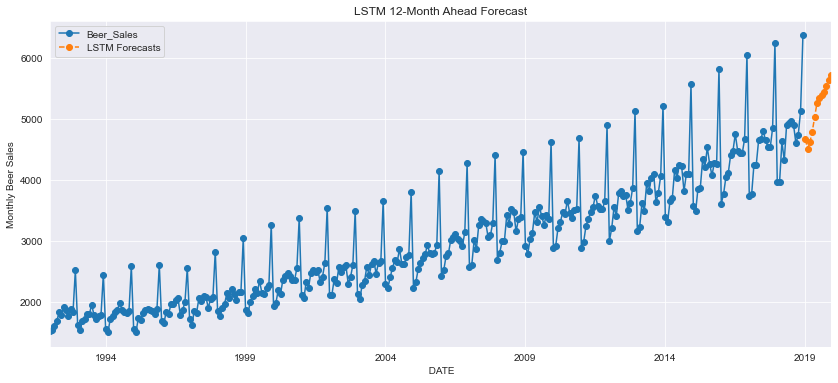

In [123]:
# Plot comprising the original time series,and the 12-month LSTM forecasts
ax = data.plot(figsize=(14, 6), marker='o', linestyle='-')
lstm_forecast_df.plot(ax=ax, marker='o', linestyle='--')
plt.title('LSTM 12-Month Ahead Forecast')
plt.ylabel('Monthly Beer Sales')
plt.xlabel('DATE')

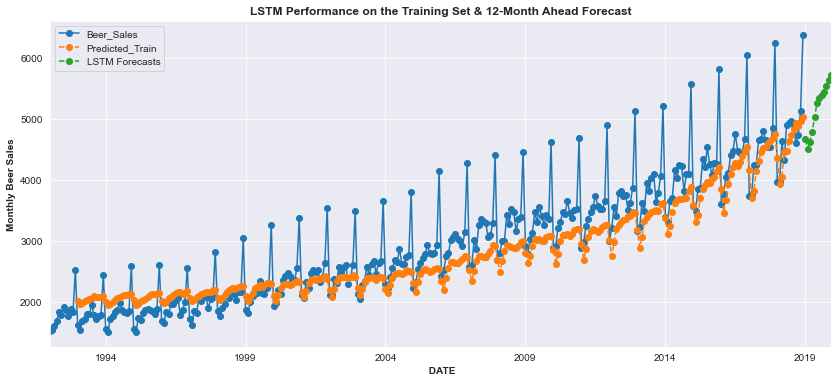

In [124]:
# Plot comprising the LSTM performance on the training set along with the 12-month ahead forecasts
ax=data.plot(figsize=(14,6),marker='o',linestyle='-')
f_train_df.plot(ax=ax,marker='o',linestyle='dashed')
lstm_forecast_df.plot(ax=ax,marker='o',linestyle='--')
plt.title('LSTM Performance on the Training Set & 12-Month Ahead Forecast',fontweight='bold')
plt.ylabel('Monthly Beer Sales',fontweight='bold')
plt.xlabel(' DATE',fontweight='bold');